




<h2 id='part1'>Analyzing Starbucks promotion effective</h2>

The starbuck dataset simulates consumer behavior, specifically how people respond to different types of promotional offers (BOGO, discount, and informational). Each simulated person has unique characteristics that influence their buying habits.

The data records various customer actions, such as receiving, opening, and responding to offers. The focus is on the amount spent, not specific products.

The goal is to analyze the data to determine:
+ Which offer is the most successful?
+ The most effective delivery channels for each offer type

<h3 id='q1'>1. Project definition</h3>

Objective:

Build a machine learning model predicting offer success based on the demographic information and the offer details that are provided in the data
Analysis to gain insights into the effective promotion patterns related to different user groups:
+ Which offer is the most successful?
+ Determine the most effective channels for delivering each offer type to maximize customer engagement and conversion rates (which channel is the most successful)

**Metric:** 
To evaluate the effectiveness of our model, we utilize the F1-score (fbeta_score) as the primary metric. This metric represents the weighted harmonic mean of precision and recall, providing a balanced assessment of model performance.

Precision measures the accuracy of our predictions, indicating the proportion of correctly identified successful offers among all predicted successful offers. Recall quantifies the model's ability to identify all actual successful offers.

In the context of offer effectiveness, both precision and recall are crucial. High precision minimizes wasted resources by ensuring that offers are only sent to customers likely to complete them. High recall maximizes potential revenue by identifying all suitable customers for a particular offer.

Considering the potential cost associated with sending irrelevant offers (lost resources) and the missed opportunities of not reaching suitable customers (lost revenue), we prioritize precision slightly more than recall. Therefore, we set beta = 0.5 in the fbeta_score calculation, effectively giving precision twice the weight of recall in the final evaluation.

<h3 id='q1'>2. Analysis</h3>

**1.** Data Exploration

Import libraries


In [2]:
import pandas as pd
import numpy as np

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import fbeta_score, classification_report

from sklearn.model_selection import GridSearchCV
%matplotlib inline

### a.  portfolio data

According to the information provided by Udacity, the schema is as follows:

**portfolio.json**
Offers sent during 30-day test period (10 offers x 6 fields)

<li>reward: (numeric) money awarded for the amount spent <br>
<li>channels: (list) web, email, mobile, social<br>
<li>difficulty: (numeric) money required to be spent to receive reward<br>
<li>duration: (numeric) time for offer to be open, in days<br>
<li>offer_type: (string) bogo, discount, informational<br>
<li>id: (string/hash)<br>

There are three types of offers that can be sent: <br>
<li>buy-one-get-one (BOGO): a user needs to spend a certain amount to get a reward equal to that threshold amount<br>
<li>discount: a user gains a reward equal to a fraction of the amount spent<br>
<li>informational: there is no reward, but neither is there a requisite amount that the user is expected to spend<br>

In [3]:
# read in the json files
portfolio = pd.read_json('../data/portfolio.json', orient='records', lines=True)
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


Check for datasize

In [4]:
portfolio.shape

(10, 6)

Check for null value

In [5]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

Check duplicate

In [6]:
portfolio.id.nunique()

10

There is no duplicate in portfolio. Check for offer type

In [7]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

There are 10 offer with 4 of bogo and 4 discount types, and 2 informational types.

### b. Profile data

Profile data for customers is provided in the `profile` dataset. The schema and variables are as follows: 

**profile.json**
Rewards program users (17000 users x 5 fields)
* gender: (categorical) M, F, O, or null
* age: (numeric) missing value encoded as 118
* id: (string/hash)
* became_member_on: (date) format YYYYMMDD
* income: (numeric)

In [8]:
profile = pd.read_json('../data/profile.json', orient='records', lines=True)
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


The gender, income and age in 5 first row contains invalid/null data. It hints that we can filter outliner, invalid data later
Check for null value

In [9]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

There are 2175 gender, income empty. But id, age, become_member_on is not null. <br>
Check some record of null data

In [10]:
profile[['gender','income','age']][profile['gender'].isnull()].head()

,gender,income,age
0,None,NaN,118
2,None,NaN,118
4,None,NaN,118
6,None,NaN,118
7,None,NaN,118


As we can see above, the age=118 column corresponds with the null gender and income columns so we can  drop them during preprocessing.

age distribution

<Axes: >

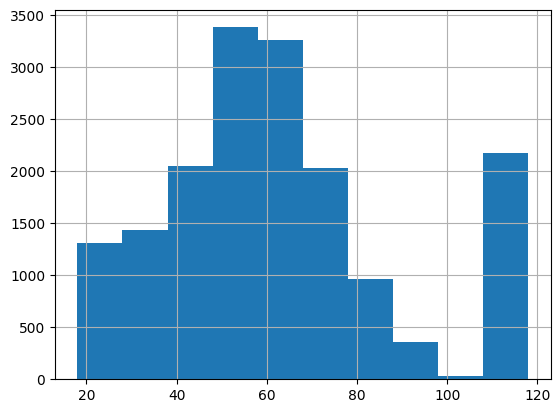

In [11]:
profile.age.hist()

Age > 100 seems to not much meaning, check number of record with age > 100

In [12]:
#check count of age=118 value and corresponding gender and income columns
print(profile[profile['age']>100].count())
profile[['gender','income','age']][profile['age']>100].head()

gender                 5
age                 2180
id                  2180
became_member_on    2180
income                 5
dtype: int64


,gender,income,age
0,None,NaN,118
2,None,NaN,118
4,None,NaN,118
6,None,NaN,118
7,None,NaN,118


Visualize distribution of income

<Axes: >

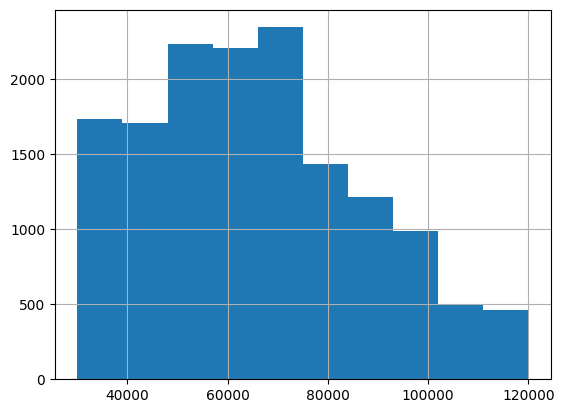

In [13]:
profile.income.hist()

Visualize distribution of become_member by year

<Axes: >

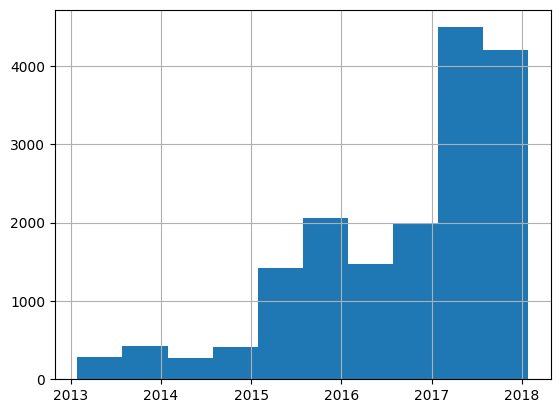

In [14]:
(profile.became_member_on/10000).hist()

### c. Transactional records

The schema for the transactional data is as follows:

**transcript.json**
Event log (306648 events x 4 fields)

* person: (string/hash)
* event: (string) offer received, offer viewed, transaction, offer completed
* value: (dictionary) different values depending on event type
    * offer id: (string/hash) not associated with any "transaction"
    * amount: (numeric) money spent in "transaction"
    * reward: (numeric) money gained from "offer completed"
* time: (numeric) hours after start of test

In [15]:
transcript = pd.read_json('../data/transcript.json', orient='records', lines=True)
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [16]:
transcript.shape

(306534, 4)

Check for null

In [17]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

There is no null data in transcript data.
Check for the number of unique user in transcript

In [18]:
transcript['person'].nunique()

17000

The number of people in transcript are the same as the number of people in the profile data => the data mapping between profile and transcript seem to match (still need more verification)

<h3 id='q1'>3. Answering Research Questions </h3>

**1.** Data preprocessing

The main idea of build model is that we trying to build a datamart which contains all information we need.
After that, we only feed our datamart into difference model or analysis to answer need question.

The channel data type in portfolio is list. It's hard to analysis so we expand that column in to 4 other channel columns. Do the same with offer type (by convert the type to column, we can easier to build the model later)

In [19]:

portfolio['channel_email'] = portfolio.channels.apply(lambda x: 1 if 'email' in str(x) else 0)
portfolio['channel_mobile'] = portfolio.channels.apply(lambda x: 1 if 'mobile' in str(x) else 0)
portfolio['channel_social'] = portfolio.channels.apply(lambda x: 1 if 'social' in str(x) else 0)
portfolio['channel_web'] = portfolio.channels.apply(lambda x: 1 if 'web' in str(x) else 0)

portfolio['bogo'] = portfolio.offer_type.apply(lambda x: 1 if 'bogo' in str(x) else 0)
portfolio['discount'] = portfolio.offer_type.apply(lambda x: 1 if 'discount' in str(x) else 0)
portfolio['informational'] = portfolio.offer_type.apply(lambda x: 1 if 'informational' in str(x) else 0)

portfolio.drop(['channels', 'offer_type'],axis=1,inplace=True)
portfolio


,reward,difficulty,duration,id,channel_email,channel_mobile,channel_social,channel_web,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


Remove invalid data from profile

In [20]:
profile = profile[profile['age']<100]
profile.shape

(14808, 5)

Expand the value of transcript dataframe

In [21]:
transcript=pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript.head()

,person,event,value,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


There are two difference offer_id column representative for the same data. So we merge that two column

In [22]:
#create new column to ensure only one offer_id column
transcript['offer_id_new']=np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),transcript['offer_id'],transcript['offer id'])
transcript.drop(['offer id','offer_id','value'],axis=1,inplace=True)
transcript.rename(columns={'offer_id_new':'offer_id'},inplace=True)

transcript.head()

,person,event,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


Because one person can receive many offer and one offer can have multiple state, so we will recalculate the final state of each offer for each person.
For example, offer with state from: 
offer received -> offer viewed-> transaction -> offer completed can be understand that is an effective offer.
In the code below, we use 4 bit to indicate each state of offer (after that we can easily understand how many states that one specific offer go through)

In [23]:
def get_offer_state(event):
    if event == 'offer received':
        return 1
    
    if event == 'offer viewed':
        return 2

    if event == 'transaction':
        return 4
    if event == 'offer completed':
        return 8
    return 0
    
datas = []


person = ''
offer_id = ''
data = ''
num_orphan_transaction = 0
transcript=transcript.sort_values(['person','time'])
for index, row in transcript.iterrows():
    if (row['person'] == person) and (row['offer_id'] == offer_id):
           
        data['event'] = row['event']
        # same journey, update info
        data['offer_state'] = data['offer_state'] | get_offer_state(row['event'])
        data['time_end'] = row['time']
        data['reward'] = data['reward'] + np.nan_to_num(row['reward'], 0)        
    else:
        if row['event'] == 'transaction':
            # fill value for transaction, process same as have person and offer_id
            if (data != '') and ((data['offer_state'] > 0) or (abs(data['time_end'] - row['time'])<1)):
                data['offer_state'] = data['offer_state'] | 4
                data['event'] = row['event']
                data['amount'] = data['amount'] + row['amount']
            else:
                if data != '':
                    datas.append(data)
                num_orphan_transaction = num_orphan_transaction+1
                data = {'person':row['person'],'offer_id':num_orphan_transaction,
                        'amount':np.nan_to_num(row['amount'], 0), 
                        'reward':np.nan_to_num(row['reward'], 0),'time_start':row['time'],'time_end':row['time'],'event':row['event'], 'offer_state':get_offer_state(row['event'])}
                datas.append(data)
                data = ''
        else:
            if data != '':
                datas.append(data)
            
            data = {'person':row['person'],'offer_id':row['offer_id'],
                    'amount':np.nan_to_num(row['amount'], 0), 
                    'reward':np.nan_to_num(row['reward'],0),'time_start':row['time'],'time_end':row['time'],'event':row['event'], 'offer_state':get_offer_state(row['event'])}
            person = row['person']
            offer_id = row['offer_id']
if data != '':
    datas.append(data)

datamart = pd.DataFrame(datas)

datamart.head(10)

,person,offer_id,amount,reward,time_start,time_end,event,offer_state
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,22.16,0.0,168,192,transaction,7
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.00,0.0,336,372,offer viewed,3
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,8.57,5.0,408,456,offer viewed,15
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,27.67,2.0,504,540,transaction,15
4,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,69.20,2.0,576,576,transaction,13
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,4.09,0.0,168,630,offer viewed,7
6,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,13.49,0.0,0,6,transaction,7
7,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,11.93,3.0,168,252,offer completed,15
8,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0,336,354,offer viewed,3
9,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,0.0,408,432,offer viewed,3


Verify on one person's records to make sure everything work

In [24]:
transcript=transcript.sort_values(['person','time'])
transcript[(transcript['person']=='0009655768c64bdeb2e877511632db8f')]

,person,event,time,amount,reward,offer_id
55972,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
89291,0009655768c64bdeb2e877511632db8f,transaction,228,22.16,NaN,NaN
113605,0009655768c64bdeb2e877511632db8f,offer received,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed
153401,0009655768c64bdeb2e877511632db8f,offer received,408,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
168412,0009655768c64bdeb2e877511632db8f,transaction,414,8.57,NaN,NaN
168413,0009655768c64bdeb2e877511632db8f,offer completed,414,NaN,5.0,f19421c1d4aa40978ebb69ca19b0e20d
187554,0009655768c64bdeb2e877511632db8f,offer viewed,456,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
204340,0009655768c64bdeb2e877511632db8f,offer received,504,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4


Merge transcript with porfolio on offer_id column.

In [25]:
#join transcript with offer type
datamart=datamart.merge(portfolio,how='left',left_on='offer_id',right_on='id')
datamart.loc[(datamart['time_end']-datamart['time_start'])<=datamart['duration']*24,'valid_completed_duration']=1
datamart.loc[(datamart['offer_state']>8),'offer_successful']=1

datamart['reward']=np.where(datamart['reward_x'].isnull(),datamart['reward_y'],datamart['reward_x'])
datamart.drop(['reward_x','reward_y'],axis=1,inplace=True)

datamart.head(10)

,person,offer_id,amount,time_start,time_end,event,offer_state,difficulty,duration,id,channel_email,channel_mobile,channel_social,channel_web,bogo,discount,informational,valid_completed_duration,offer_successful,reward
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,22.16,168,192,transaction,7,0,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1,1.0,NaN,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.00,336,372,offer viewed,3,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1,1.0,NaN,0.0
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,8.57,408,456,offer viewed,15,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0,1.0,1.0,5.0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,27.67,504,540,transaction,15,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0,1.0,1.0,2.0
4,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,69.20,576,576,transaction,13,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0,1.0,1.0,2.0
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,4.09,168,630,offer viewed,7,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0,NaN,NaN,0.0
6,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,13.49,0,6,transaction,7,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1,1.0,NaN,0.0
7,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,11.93,168,252,offer completed,15,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0,1.0,1.0,3.0
8,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,0.00,336,354,offer viewed,3,0,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1,1.0,NaN,0.0
9,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,408,432,offer viewed,3,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0,1.0,NaN,0.0


There are several rows which have NaN value of [offer_successful], so we cleansing it by fill the 0

In [26]:
datamart.loc[(datamart['offer_state']<=8),'offer_successful']=0


**2.** Feature engineering

The `became_member_on` column were in date format. Hence in order to extract meaningful insights from that feature, we can convert it as a feature indicating tenure of membership. There could be some influence in how long someone has been a member, with whether he takes up an offer.

In [27]:
#merge to get user demographic profile
df=datamart.merge(profile,how='inner',left_on='person', right_on= 'id')

df['year']=pd.Series([int(str(x)[:4]) for x in df['became_member_on']])
df['month']=pd.Series([int(str(x)[-3]) for x in df['became_member_on']])

df.drop(['became_member_on','id_x', 'id_y'],axis=1,inplace=True)

df[['valid_completed_duration']] = df[['valid_completed_duration']].fillna(value=0)

df.head()

,person,offer_id,amount,time_start,time_end,event,offer_state,difficulty,duration,channel_email,...,discount,informational,valid_completed_duration,offer_successful,reward,gender,age,income,year,month
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,22.16,168,192,transaction,7,0,3,1,...,0,1,1.0,0.0,0.0,M,33,72000.0,2017,4
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.00,336,372,offer viewed,3,0,4,1,...,0,1,1.0,0.0,0.0,M,33,72000.0,2017,4
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,8.57,408,456,offer viewed,15,5,5,1,...,0,0,1.0,1.0,5.0,M,33,72000.0,2017,4
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,27.67,504,540,transaction,15,10,10,1,...,1,0,1.0,1.0,2.0,M,33,72000.0,2017,4
4,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,69.20,576,576,transaction,13,10,7,1,...,1,0,1.0,1.0,2.0,M,33,72000.0,2017,4


Answer the question: 
+ Which offer is the most successful?
+ The most effective delivery channels for each offer type

In [28]:
num_bogo_offer = df[df['bogo']==1].shape[0]
num_bogo_offer_success = df[(df['bogo']==1) & (df['offer_successful']==1)].shape[0]
num_discount_offer = df[df['discount']==1].shape[0]
num_discount_offer_success = df[(df['discount']==1) & (df['offer_successful']==1)].shape[0]

total_amount = df[(df['bogo']==1) & (df['offer_successful']==1)]['amount'].sum()
print(total_amount)
total_amount = df[(df['discount']==1) & (df['offer_successful']==1)]['amount'].sum()
print(total_amount)
print(f'number of bogo offer success {num_bogo_offer_success} over total of bogo offer {num_bogo_offer}, percentage: {num_bogo_offer_success/num_bogo_offer}')
print(f'number of discount offer success {num_discount_offer_success} over total of bogo offer {num_discount_offer}, percentage: {num_discount_offer_success/num_discount_offer}')

617557.68
669496.49
number of bogo offer success 12756 over total of bogo offer 27288, percentage: 0.46745822339489884
number of discount offer success 13533 over total of bogo offer 28935, percentage: 0.4677034733022291


In [29]:
bogo_offer = df[(df['bogo']==1)]
discount_offer = df[(df['discount']==1) ]

bogo_offer_success = df[(df['bogo']==1) & (df['offer_successful']==1)]
discount_offer_success = df[(df['discount']==1) & (df['offer_successful']==1)]

channels = ['channel_web', 'channel_email', 'channel_mobile', 'channel_social']

for channel in channels:
    num_success = len(bogo_offer_success[df[channel]==1]) + len(discount_offer_success[df[channel]==1]) 
    num_offer = len(bogo_offer[df[channel]==1]) + len(discount_offer[df[channel]==1]) 
    print(f'number of {channel} success item {num_success}, success rate {num_success/num_offer}')

number of channel_web success item 23283, success rate 0.4720132990046019


C:\Users\CuongVT1\AppData\Local\Temp\ipykernel_26796\2696090400.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  num_success = len(bogo_offer_success[df[channel]==1]) + len(discount_offer_success[df[channel]==1])
C:\Users\CuongVT1\AppData\Local\Temp\ipykernel_26796\2696090400.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  num_success = len(bogo_offer_success[df[channel]==1]) + len(discount_offer_success[df[channel]==1])
C:\Users\CuongVT1\AppData\Local\Temp\ipykernel_26796\2696090400.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  num_offer = len(bogo_offer[df[channel]==1]) + len(discount_offer[df[channel]==1])
C:\Users\CuongVT1\AppData\Local\Temp\ipykernel_26796\2696090400.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  num_offer = len(bogo_offer[df[channel]==1]) + len(discount_offer[df[channel]==1])
C:\Users\CuongVT1\AppData\Local\Temp\ipy

number of channel_email success item 26289, success rate 0.4675844405314551
number of channel_mobile success item 24027, success rate 0.4934486157890413
number of channel_social success item 17509, success rate 0.5056896950092421


C:\Users\CuongVT1\AppData\Local\Temp\ipykernel_26796\2696090400.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  num_success = len(bogo_offer_success[df[channel]==1]) + len(discount_offer_success[df[channel]==1])
C:\Users\CuongVT1\AppData\Local\Temp\ipykernel_26796\2696090400.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  num_success = len(bogo_offer_success[df[channel]==1]) + len(discount_offer_success[df[channel]==1])
C:\Users\CuongVT1\AppData\Local\Temp\ipykernel_26796\2696090400.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  num_offer = len(bogo_offer[df[channel]==1]) + len(discount_offer[df[channel]==1])
C:\Users\CuongVT1\AppData\Local\Temp\ipykernel_26796\2696090400.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  num_offer = len(bogo_offer[df[channel]==1]) + len(discount_offer[df[channel]==1])


Predicting Offer Success

Now we already have the data which already clean and do feature engineering.
We can now use this data to fit into the model with a litle of processing.

Tasks:

• Prepare the data:<br>
- Encode the column (already done)<br>
- Drop output column, convert output to Y vector<br>
- Drop columns which may explose output information to the model: person, offer_id, amount, award, offer_state, valid_completed_duration, event<br>
- Drop columns which we don't want model to rely on for some reason: in here we drop gender column to ensure model does not use these information.<br>
- Drop un meaning column: time_start, time_end, difficulty<br>

• Spit train and test data: in this model, we can spit 80-20 ratio (80% of data for train)<br>
• Train the model<br>
• Evaluate the model<br>
• Use search grid to find better parameters<br>

Note: In this problem, as discuss on the overview section, we use the F1 score(fbeta_score) as the model metric To evaluate the effectiveness of the model because the precision seems to have more meaning compare to recall, so we choose beta = 0.5 (make precision twice as importance as recall)

In [40]:
def ClassificationModel(df, model=RandomForestClassifier(max_depth=20, random_state=42)):
    y = df.pop('offer_successful')
    
    X = df.drop(columns=['person', 'offer_id', 'time_start', 'gender','time_end', 'amount', 'reward','difficulty',
                          'offer_state', 'valid_completed_duration', 'event'])    

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
    
    model.fit(X_train, y_train)
    
    model_predictions = model.predict(X_test)
    print(classification_report(y_test, model_predictions))
    print("Overall model accuracy (weighted equal between precion and recall):\t {}".format(fbeta_score(y_test, model_predictions, beta = 1, average='weighted' )))
    print("Overall model accuracy:\t {}".format(fbeta_score(y_test, model_predictions, beta = 0.5, average='weighted' )))
    return model

In [41]:
overall_model_randf = ClassificationModel(df.copy(deep=True))

              precision    recall  f1-score   support

         0.0       0.75      0.78      0.77      8455
         1.0       0.63      0.59      0.61      5289

    accuracy                           0.71     13744
   macro avg       0.69      0.68      0.69     13744
weighted avg       0.70      0.71      0.70     13744

Overall model accuracy (weighted equal between precion and recall):	 0.7047352054643153
Overall model accuracy:	 0.7039700086640673


Now try to build the model with difference classifier (GradientBoostingClassifier). 

In [42]:
overall_model_gb = ClassificationModel(df.copy(deep=True), GradientBoostingClassifier(random_state=42))

              precision    recall  f1-score   support

         0.0       0.76      0.81      0.78      8455
         1.0       0.66      0.59      0.62      5289

    accuracy                           0.72     13744
   macro avg       0.71      0.70      0.70     13744
weighted avg       0.72      0.72      0.72     13744

Overall model accuracy (weighted equal between precion and recall):	 0.7215479315811689
Overall model accuracy:	 0.7207624519456232


**Model evaluation**<br>
Based on F1-score, we can found that the GradientBoostingClassifier seems to better than RandomForestClassifier.
Therefore I choose GradientBoostingClassifier as a baseline model.
Now we trying to optimize GradientBoostingClassifier by using GridSearchCV to find the best model

In [43]:
overall_model_gb.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [58]:
param_grid={'n_estimators': [50, 100, 500],
            'learning_rate': [0.1,0.7, 1]}

cv = GridSearchCV(overall_model_gb, param_grid=param_grid, n_jobs=-1, scoring = 'roc_auc')

overall_model = ClassificationModel(df.copy(deep=True), cv)

              precision    recall  f1-score   support

         0.0       0.76      0.81      0.78      8455
         1.0       0.66      0.60      0.63      5289

    accuracy                           0.73     13744
   macro avg       0.71      0.70      0.71     13744
weighted avg       0.72      0.73      0.72     13744

Overall model accuracy (weighted equal between precion and recall):	 0.7241926585437084
Overall model accuracy:	 0.7234338592677678


In [59]:
cv.best_params_


{'learning_rate': 0.1, 'n_estimators': 500}

Model Evaluation based on F1-scoreApply gridsearch we can found better parameter for our model. 

After find the best parameter we can use it to build the final model

In [61]:
final_model = ClassificationModel(df.copy(deep=True), GradientBoostingClassifier(learning_rate=0.1, n_estimators=500, random_state=42))

              precision    recall  f1-score   support

         0.0       0.76      0.81      0.78      8455
         1.0       0.66      0.60      0.63      5289

    accuracy                           0.73     13744
   macro avg       0.71      0.70      0.71     13744
weighted avg       0.72      0.73      0.72     13744

Overall model accuracy (weighted equal between precion and recall):	 0.7241926585437084
Overall model accuracy:	 0.7234338592677678


Now we analyse the most importance feature of the final model

In [45]:
def most_important_features(df, model):
    X = df.drop(columns=['offer_successful', 'person', 'offer_id', 'time_start', 'gender','time_end', 'amount', 'reward','difficulty',
                        'offer_state', 'valid_completed_duration', 'event'])    

    feat_imp = pd.DataFrame(model.feature_importances_, index=X.columns,
                            columns=['importance']).sort_values('importance', ascending=False).reset_index()
    feat_imp.rename(columns={'index':'feature'},inplace=True)
    
    plot = sns.catplot(data=feat_imp.reset_index(), y='feature', x='importance', kind='bar', aspect=2)
    plot.set(title='Feature importance')
    
    return feat_imp

,feature,importance
0,informational,0.399124
1,year,0.216168
2,duration,0.136148
3,income,0.093043
4,channel_mobile,0.052947
5,month,0.030603
6,age,0.024820
7,discount,0.017174
8,channel_social,0.016588
9,bogo,0.008399


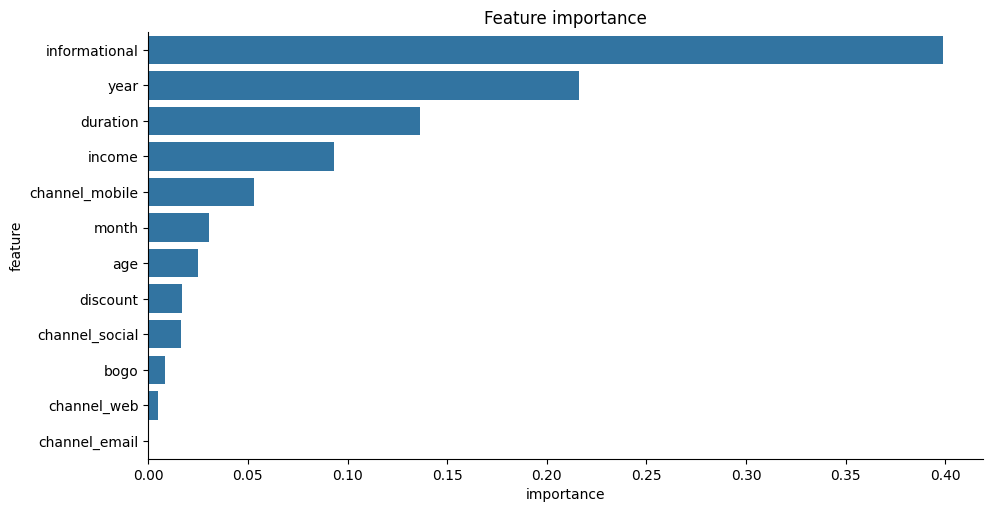

In [62]:
most_important_features(df.copy(deep=True), final_model)


**Conclusion**<br>
In this project, my goal was to predict offer success based on the available offer and customer information. I have built a simple classification model using a random forest classifier,GradientBoostingClassifier and found out GradientBoostingClassifier works for this case.


The most relevant factors for offer success based on the model are:
Informational
Membership duration
offer Duration
Income
channel mobile

Which offer is the most successful?
In term of efficiency, the conversation rate between discount and bogo seem to be similar. 
Choose the right offer also depends on the actual situation (maybe another perspective rather than analysis in this project).

Which channel is better?
It seems that social channel has best conversation rate, but in the model's feature importance analysis, the mobile feature have higher impact value, this hint us to optimize the mobile channel to get better chance to improve conversation rate. 

**Justification** 
The best score is created by the GradientBoostingClassifier model with grid search, as its validation F1 score is 0.7268. The RandomForestClassifier model scores well as well compared to the GradientBoostingClassifier, with a test F1 score of 70.47. 
But we can take deeper analysis and optimize of RandomForestClassifier.
After apply grid search on RandomForestClassifier we also get the model improve to 0.7238 (F1 score), similar to GradientBoostingClassifier.
The importance features of two models also difference, in GradientBoostingClassifier information is most importance feature but in RandomForestClassifier the age is more importance.
See the justification code below

**Improvement** 
The basedline(final) model have overall F1 score around 72%. However we still have room for enhancement, below are some ideas of enhancement
+ Collect more data to analyse and training model
+ Fit more columns to the model like: gender, reward
+ Normalize the data such as convert income in range 0-1 or log of current income.
+ Consider to multiple classifiction such as offer view, offer read, transaction and complete order
+ Optimize hyper parameter, choose another classifier.

**Reflexion**
Build the model is interesting task, there are many way to build and optimize model.
However to have better model we shoud align the model metric with the business perspective to have better direction of opitmization.

From my view point:
+ We should alway try to answer the business questions, how we can answer these questions with the available data.
+ Build baseline first, after that we can findout many other models and optimization.

In [51]:
overall_model_randf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [54]:
param_grid={'n_estimators': [50, 100, 500],
            'max_depth': [5, 10, 20]
}

cv = GridSearchCV(overall_model_randf, param_grid=param_grid, n_jobs=-1, scoring = 'roc_auc')
overall_model_1 = ClassificationModel(df.copy(deep=True), cv)

              precision    recall  f1-score   support

         0.0       0.77      0.79      0.78      8455
         1.0       0.65      0.62      0.64      5289

    accuracy                           0.73     13744
   macro avg       0.71      0.71      0.71     13744
weighted avg       0.72      0.73      0.72     13744

Overall model accuracy (weighted equal between precion and recall):	 0.7243330357008518
Overall model accuracy:	 0.7238029389896791


In [55]:
cv.best_params_

{'max_depth': 10, 'n_estimators': 500}

In [56]:
overall_model_randf = ClassificationModel(df.copy(deep=True), model=RandomForestClassifier(max_depth=10, random_state=42))

              precision    recall  f1-score   support

         0.0       0.77      0.79      0.78      8455
         1.0       0.65      0.62      0.64      5289

    accuracy                           0.73     13744
   macro avg       0.71      0.71      0.71     13744
weighted avg       0.72      0.73      0.72     13744

Overall model accuracy (weighted equal between precion and recall):	 0.7241759285844397
Overall model accuracy:	 0.7236637261701979


,feature,importance
0,duration,0.242734
1,informational,0.202955
2,year,0.176318
3,income,0.112927
4,age,0.059795
5,discount,0.040015
6,channel_social,0.036804
7,month,0.036690
8,bogo,0.035754
9,channel_mobile,0.035111


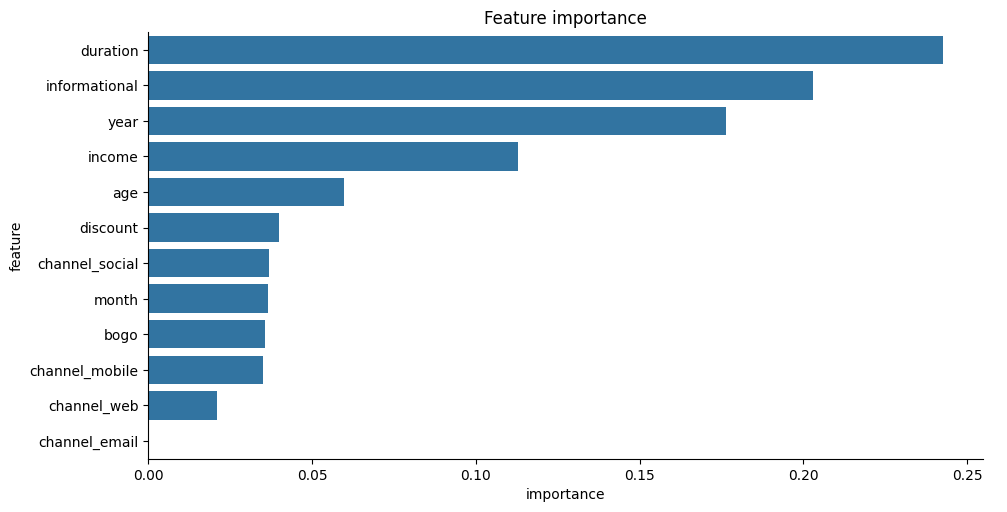

In [63]:
most_important_features(df.copy(deep=True), overall_model_randf)
